In [ ]:
#| default_exp rosbag_tools

# rosbag_tools

> A toolset for rosbag created by arg lab.

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#|export
#nbdev_comment from __future__ import print_function

import os
import argparse
import cv2
import rosbag
import yaml
import time
import apriltag
import pytransform3d.rotations as pr
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
from sensor_msgs.msg import Image
from cv_bridge import CvBridge

class arg_bag_extracter:
    def __init__(self, bag_file, output_dir, image_topic, depth_topic): 
        self.bag_file = bag_file
        self.bag = rosbag.Bag(self.bag_file, "r")
        self.output_dir = output_dir
        self.image_topic = image_topic
        self.depth_topic = depth_topic
        plt.rcParams['figure.figsize'] = (40, 40)        # large images

    def extract(self):
        bridge = CvBridge()
        count = 0
        for topic, msg, t in self.bag.read_messages(topics=[self.image_topic]):
            cv_img = bridge.imgmsg_to_cv2(msg, "bgr8")
            cv2.imwrite(os.path.join(self.output_dir+"rgb/", "color%06i.png" % count), cv_img)
            count += 1
        count = 0
        for topic, msg, t in self.bag.read_messages(topics=[self.depth_topic]):
            cv_img = bridge.imgmsg_to_cv2(msg, "16UC1")
            cv2.imwrite(os.path.join(self.output_dir+"depth/", "depth%06i.png" % count), cv_img)
            count += 1
        self.bag.close()
        print("done")
        return
    
    def detect_apriltag(self):
        img_path = 'extract/rgb/color000003.png'
        depth_path = 'extract/depth/depth000003.png'
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        depth = cv2.imread(depth_path, -cv2.IMREAD_ANYDEPTH)
        dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Visualization
        plt.subplot(131),plt.imshow(dst, cmap = 'brg')
        plt.title('rgb'), plt.xticks([]), plt.yticks([])
        #apriltag detect
        options = apriltag.DetectorOptions(families="tag36h11")
        detector = apriltag.Detector(options)
        results = detector.detect(gray)
        detection_results, dimg = detector.detect(gray, return_image=True)
        for r in results:
            print("id: {}, center: {}".format(r.tag_id, r.center))
        print("[INFO] {} total AprilTags detected".format(len(results)))
        plt.subplot(132),plt.imshow(dst, cmap = 'brg')
        plt.title('AprilTags'), plt.xticks([]), plt.yticks([])
        for r in detection_results:
            (c_x, c_y) = (int(r.center[0]), int(r.center[1]))
            d = depth[c_y, c_x]
        print("depth of Apriltag {}: {})".format(r.tag_id, d))
        plt.subplot(133),plt.imshow(dimg, cmap = 'brg')
        plt.title('Filter'), plt.xticks([]), plt.yticks([])
        return
    
    def detect_near_object(self):
        img_path = 'extract/rgb/color000046.png'
        depth_path = 'extract/depth/depth000046.png'
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        depth = cv2.imread(depth_path, -cv2.IMREAD_ANYDEPTH)
        dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Visualization
        plt.subplot(131),plt.imshow(dst, cmap = 'brg')
        plt.title('rgb'), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(depth, interpolation='nearest')
        plt.title('depth'), plt.xticks([]), plt.yticks([])
        # find near
        for n in depth:
            print(n)
            print(".")
        depth_near = depth < 70
        print(depth_near)
        depth_far = depth > 50
        print(depth_far)
        count_near = 0
        count_far = 0
        for n in depth_near:
            count_near += 1
        for n in depth_far:
            if n is True:
                count_far += 1
        print(count_near)
        print(count_far)
        #
        output = dst
        #
        plt.subplot(133),plt.imshow(output, cmap = 'brg')
        plt.title('filter'), plt.xticks([]), plt.yticks([])      
        return
    
    def detect_color_block(self):
        img_path = 'extract/rgb/color000046.png'
        depth_path = 'extract/depth/depth000046.png'
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        depth = cv2.imread(depth_path, -cv2.IMREAD_ANYDEPTH)
        dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Visualization
        plt.subplot(131),plt.imshow(dst, cmap = 'brg')
        plt.title('rgb'), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(depth, interpolation='nearest')
        plt.title('depth'), plt.xticks([]), plt.yticks([])
        # Set mask for color detect
        lower_blue = np.array([110,50,50])
        upper_blue = np.array([130,255,255])
        lower_green = np.array([45,100,20])
        upper_green = np.array([75,255,255])
        lower_red = np.array([161, 155, 84])
        upper_red = np.array([179, 255, 255])
        mask_blue = cv2.inRange(img, lower_blue, upper_blue)
        mask_green = cv2.inRange(img, lower_green, upper_green)
        mask_red = cv2.inRange(img, lower_red, upper_red)      
        #define kernel size  
        kernel = np.ones((90,90),np.uint8)
        # Remove unnecessary noise from mask
        mask = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        output = cv2.bitwise_and(img, img, mask = mask)
        # Find contours from the mask
        contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        output = cv2.drawContours(output, contours, -1, (0, 0, 255), 3)
        plt.subplot(133),plt.imshow(output, cmap = 'brg')
        plt.title('filter'), plt.xticks([]), plt.yticks([])      
        return

## zed and apriltag
this section is for a bag that contains zed camera topic, and modify apriltag example

In [ ]:
cd data

[Errno 2] No such file or directory: 'data'
/home/arg/arg_ros_tools/data


In [ ]:
#| hide

import gdown
#for zed
url = "https://drive.google.com/u/1/uc?id=1WwZBE2vmJqsNQYpwDjQGd8m_mhjYN8Bj&export=download"
output = "zed.bag"
file_exists = exists("zed.bag")
if file_exists is False:
    gdown.download(url, output, quiet=False)
else:
    print("file exists")

file exists


In [ ]:
#for zed
extracter = arg_bag_extracter(bag_file="zed.bag", output_dir="extract/", image_topic="/zed/zed_node/left_raw/image_raw_color", depth_topic="/zed/zed_node/depth/depth_registered")

In [ ]:
extracter.extract()

done


id: 1, center: [246.27167208  93.54056617]
id: 2, center: [271.11858937  71.67642223]
id: 201, center: [241.81689027  63.77864736]
[INFO] 3 total AprilTags detected
depth of Apriltag 201: 3)


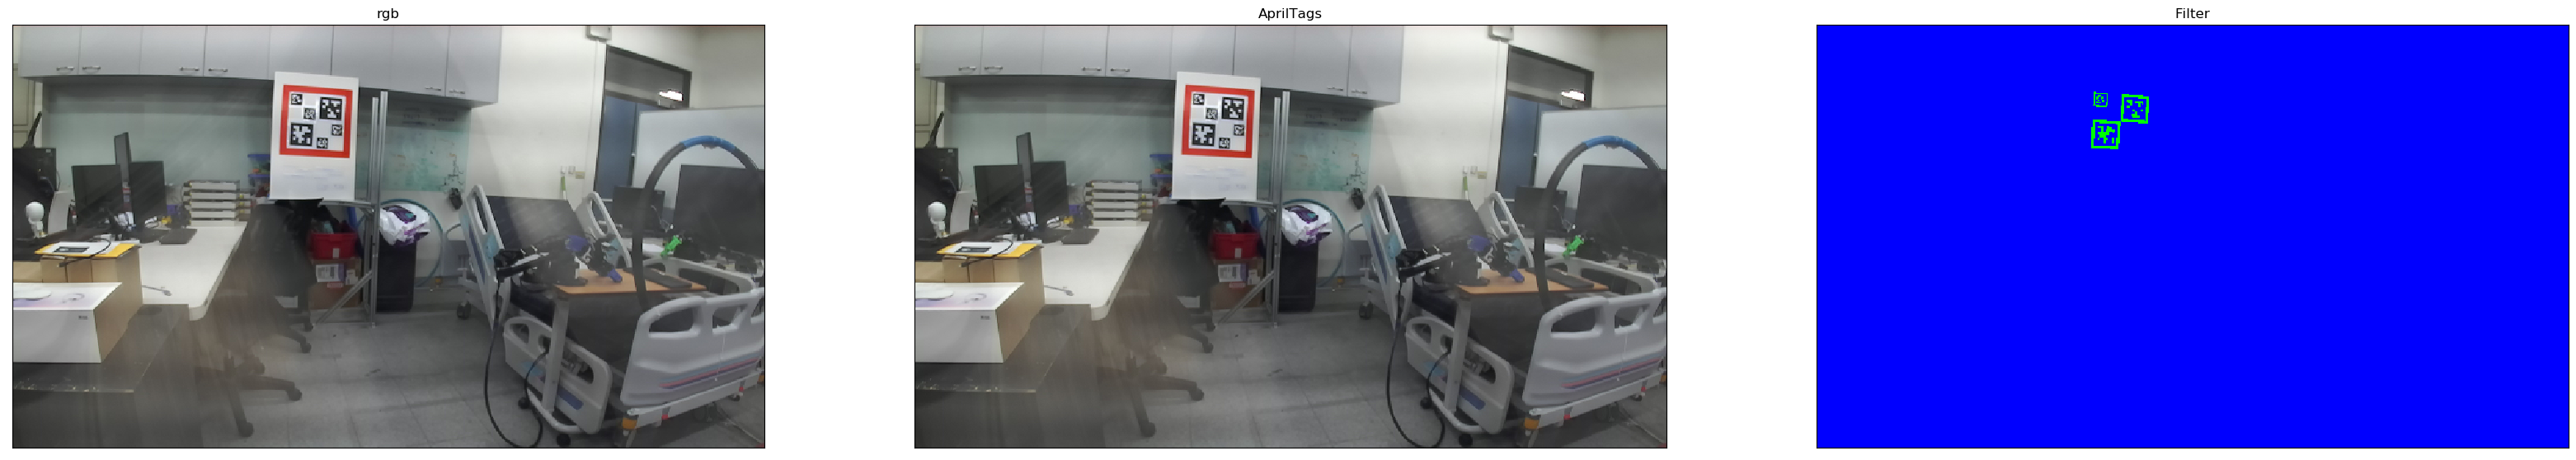

In [ ]:
extracter.detect_apriltag()

## dreamvu
this section is for a bag that contains dreamvu camera topic, and modify color example

In [ ]:
#| hide

import gdown
#for dreamvu
url = "https://drive.google.com/u/1/uc?id=1VgD1HdtB64k3IIdmdFMuxXZ5-IeuTxio&export=download"
output = "dreamvu.bag"
file_exists = exists("dreamvu.bag")
if file_exists is False:
    gdown.download(url, output, quiet=False)
else:
    print("file exists")

file exists


In [ ]:
#for dreamvu
extracter = arg_bag_extracter(bag_file="dreamvu.bag", output_dir="extract/", image_topic="/dreamvu/pal/get/left", depth_topic="/dreamvu/pal/get/depth")

In [ ]:
extracter.extract()

done


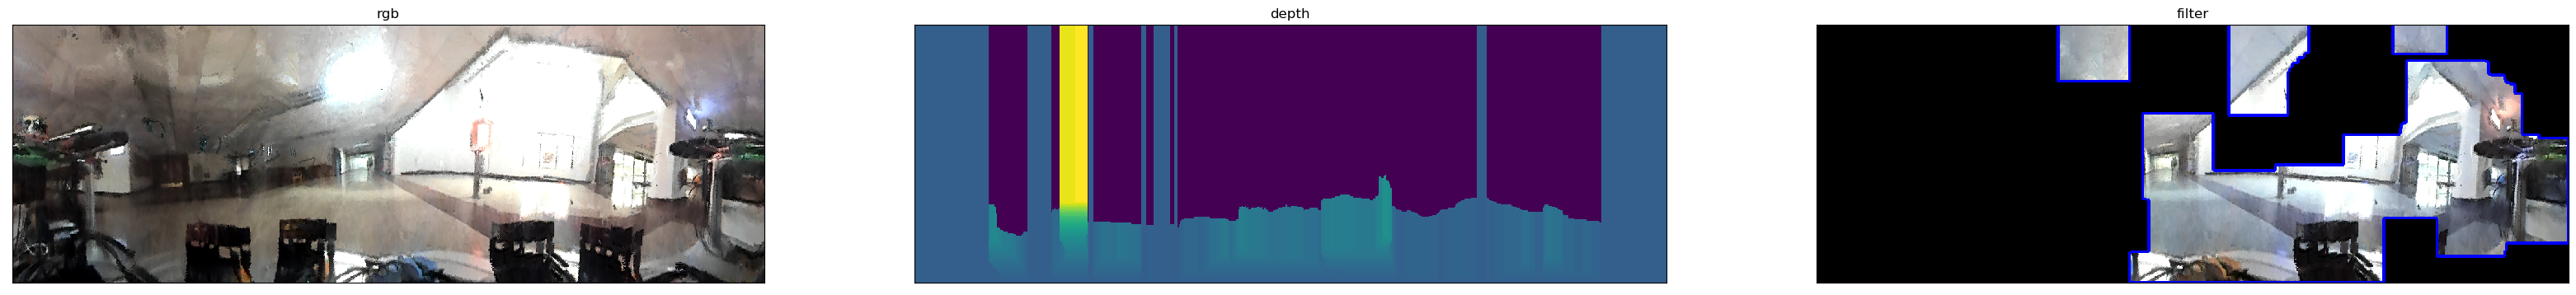

In [ ]:
extracter.detect_color_block()

[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ... 63 63 63]
.
[63 63 63 ..

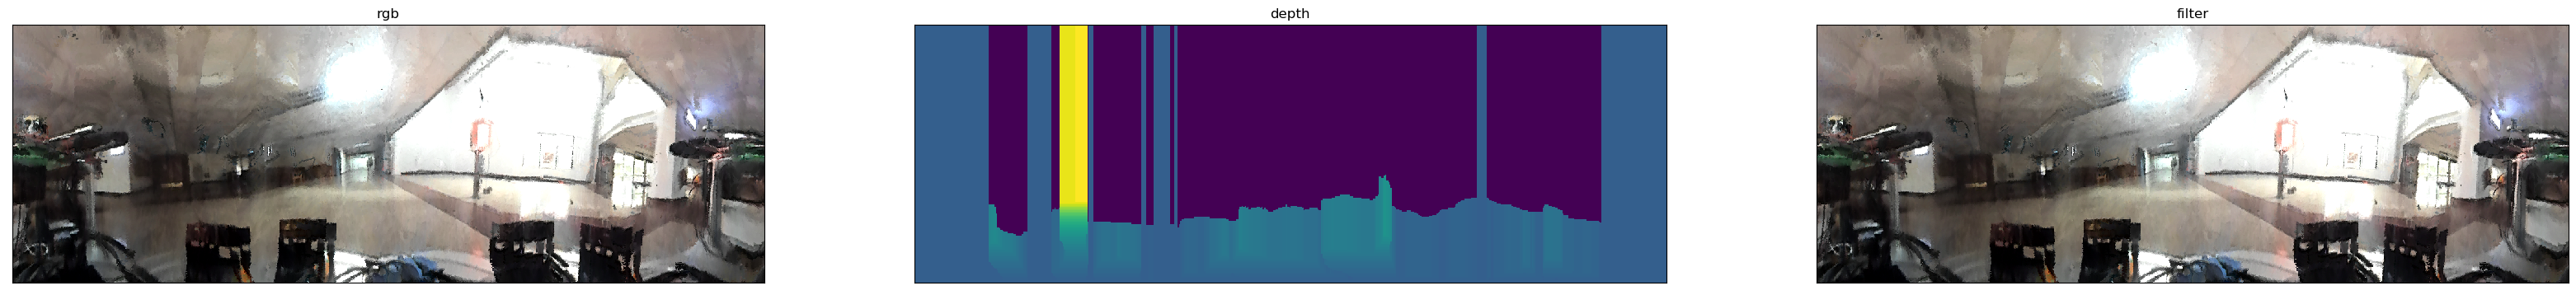

In [ ]:
extracter.detect_near_object()